# Project 3

These 4 lines are to upload and install sql

In [8]:
!dropdb -U student week11

dropdb: error: database removal failed: ERROR:  database "week11" is being accessed by other users
DETAIL:  There are 2 other sessions using the database.


In [9]:
!createdb -U student week11

createdb: error: database creation failed: ERROR:  database "week11" already exists


In [7]:
%load_ext sql

In [8]:
%sql postgresql://student@/week11

In [11]:
!pwd

/home/ubuntu/notebooks/project 3


## Ask 1

We used the csv files provided by the kaggle project, https://www.kaggle.com/datasets/threnjen/2019-airline-delays-and-cancellations.
Spesfically, we only ended up needing the 6 ONTIME_REPORTING files for the first quater of 2019 and 2020, the 2 airport_weather files for 2019 and 2020 respectively, and the airports_list file.

- ONTIME_REPORTING_01.csv
- ONTIME_REPORTING_02.csv
- ONTIME_REPORTING_03.csv
- ONTIME_REPORTING_2020_01.csv
- ONTIME_REPORTING_2020_02.csv
- ONTIME_REPORTING_2020_03.csv
- airport_weather_2019.csv
- airport_weather_2020.csv
- airports_list.csv

The ontime_reporting files made up the large majority of the data in the data set and required a lot of cleaning and alteration especially when it came to the date and times.

The airport_weather files are extra info about the most common cause of delay and cancelation, weather. It is basically just a weather report for each airport for each day. Some of the analysis we decided to do requires these weather reports so we included it in our database.

The airports_list is used to link the ONTIME_REPORTING and airport_weather files. This is because the unique airport identifier that the airport_weather files uses is different than the one the ONTIME_REPORTING files uses and the airports_list has both.

## Ask 2

1. We used CSVkit to pull out the spesific fields we needed and stack them into complete csv files
2. We created sql tables that for each other those files and laoded the data in
3. We normalized the main table by identifying related groups of contexts and putting them in their own table. This is explained fully in our star schema.
4. We used sql functions to clean spesific parts of the data.
- We altered the date and time fields so they could be made date and times types respectively
- We added a number of variables related to date and time to make information easier to query.
- We used the airports_list file to add a common variable to the weather data so it would be included in our database.

## Ask 3

1) Which airports have the highest total snowfall to total weather cancelation ratio?
2) Which days of the week has the most long distance flights and which has the most short distance flights? 
3) What city pairs have the most flights? What is the average distance between those cities?
4) Which is the top airline with carrier delays in 2019 and 2020?

## Ask 4

Our ER diagram can be found in this folder at './project 3 ISTM 4212 (2).pdf' or './project 3 ISTM 4212.jpeg'

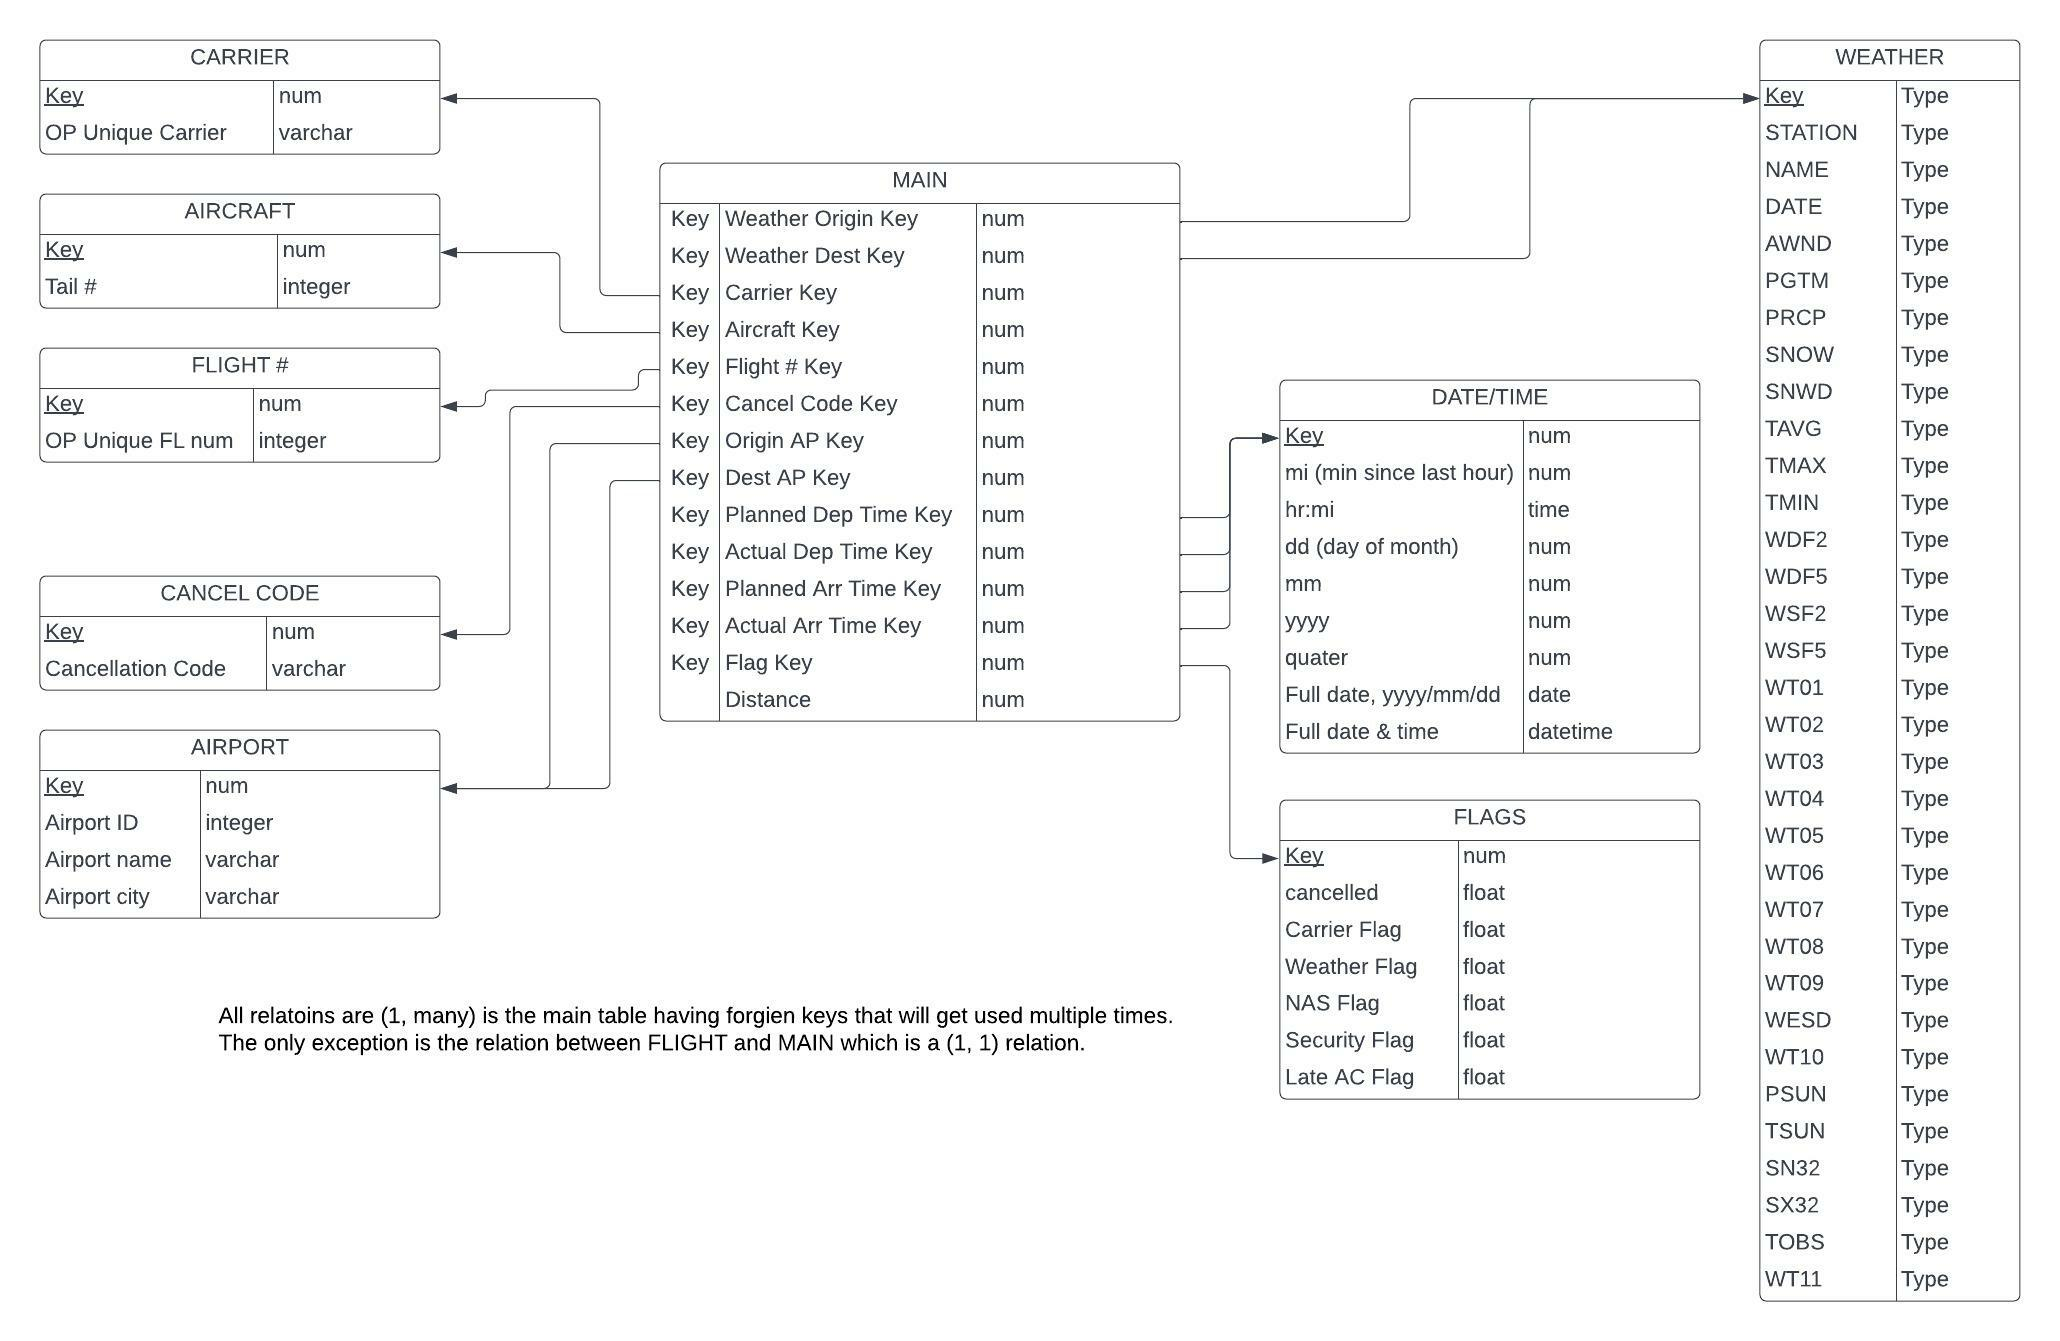

In [2]:
from IPython.display import Image
Image(filename = "./project 3 ISTM 4212.jpeg")

## Ask 5

### Build database

We spend the next few lines cleaning and altering the csv files we will load into a table. We start with the ONTIME_REPORTING files from quarter 1 and the airport_weather files for 2019 and 2020.

In [6]:
# combine 2019 monthly ontime_reporting files into first quarter file
!csvstack ONTIME_REPORTING_03.csv ONTIME_REPORTING_02.csv ONTIME_REPORTING_01.csv > ONTIME_REPORTING_Q1.csv



In [7]:
# combine 2020 monthly ontime_reporting files into first quarter file
!csvstack ONTIME_REPORTING_2020_03.csv ONTIME_REPORTING_2020_02.csv ONTIME_REPORTING_2020_01.csv > ONTIME_REPORTING_2020_Q1.csv



In [8]:
# extract first quater data from anual weather file for 2020
!csvgrep -c3 -m "2020-01-" airport_weather_2020.csv > APW_2020_01.csv
!csvgrep -c3 -m "2020-02-" airport_weather_2020.csv > APW_2020_02.csv
!csvgrep -c3 -m "2020-03-" airport_weather_2020.csv > APW_2020_03.csv

# combine all extracted files into one
!csvstack APW_2020_01.csv APW_2020_02.csv APW_2020_03.csv > airport_weather_2020_Q1.csv



In [9]:
# Same as above but need to use 2 methods of extracting data since date comes
# in 2 formates
!csvgrep -c3 -m "2019-01-" airport_weather_2019.csv > APW_01.csv
!csvgrep -c3 -r "^1/" airport_weather_2019.csv > APW_B_01.csv

!csvgrep -c3 -m "2019-02-" airport_weather_2019.csv > APW_02.csv
!csvgrep -c3 -r "^2/" airport_weather_2019.csv > APW_B_02.csv

!csvgrep -c3 -m "2019-03-" airport_weather_2019.csv > APW_03.csv
!csvgrep -c3 -r "^3/" airport_weather_2019.csv > APW_B_03.csv

# combine all extracted files into one
!csvstack APW_01.csv APW_02.csv APW_03.csv APW_B_01.csv APW_B_02.csv APW_B_03.csv > airport_weather_2019_Q1.csv



In [3]:
!csvgrep -n ONTIME_REPORTING_01.csv

  1: MONTH
  2: DAY_OF_MONTH
  3: DAY_OF_WEEK
  4: OP_UNIQUE_CARRIER
  5: TAIL_NUM
  6: OP_CARRIER_FL_NUM
  7: ORIGIN_AIRPORT_ID
  8: ORIGIN
  9: ORIGIN_CITY_NAME
 10: DEST_AIRPORT_ID
 11: DEST
 12: DEST_CITY_NAME
 13: CRS_DEP_TIME
 14: DEP_TIME
 15: DEP_DELAY_NEW
 16: DEP_DEL15
 17: DEP_TIME_BLK
 18: CRS_ARR_TIME
 19: ARR_TIME
 20: ARR_DELAY_NEW
 21: ARR_TIME_BLK
 22: CANCELLED
 23: CANCELLATION_CODE
 24: CRS_ELAPSED_TIME
 25: ACTUAL_ELAPSED_TIME
 26: DISTANCE
 27: DISTANCE_GROUP
 28: CARRIER_DELAY
 29: WEATHER_DELAY
 30: NAS_DELAY
 31: SECURITY_DELAY
 32: LATE_AIRCRAFT_DELAY
 33: 


We removed lines 15, 16, 17, 20, 21, 24, 25, and 27 from the original ONTIME_REPORTING csv files because we don't want them in the database. This is because they are not in the file description that comes with the raw data so we are not sure what they mean. In addition we don't need them to answer any of our questions.

In [16]:
!csvcut -C15,16,17,20,21,24,25,27,33 ONTIME_REPORTING_Q1.csv | head

MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,CRS_ARR_TIME,ARR_TIME,CANCELLED,CANCELLATION_CODE,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
3,2,6,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",1315,1307,1555,1549,0.00,,1025.00,,,,,
3,2,6,WN,N8686A,3231,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",1925,1926,2155,2200,0.00,,930.00,,,,,
3,2,6,WN,N201LV,3383,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",0850,0850,1115,1119,0.00,,930.00,,,,,
3,2,6,WN,N413WN,5498,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",1140,1151,1410,1424,0.00,,930.00,,,,,
3,2,6,WN,N7832A,6933,14635,RSW,"Fort Myers, FL",11259,DAL,"Dallas, TX",1405,1405,1605,1548,0.00,,1005.00,,,,,
3,2,6,WN,N492WN,3960,14635,RSW,"Fort Myers, FL",11986,GRR,"Grand Rapids, MI",1415,1413,1715,1707,0.00,,1147.00,,,,,
3,2,6,WN,N8634A,3826

In [10]:
!csvcut -C15,16,17,20,21,24,25,27,33 ONTIME_REPORTING_Q1.csv > ONTIME_REPORTING_Q1_short.csv



In [27]:
!csvgrep -n ONTIME_REPORTING_Q1_short.csv

  1: MONTH
  2: DAY_OF_MONTH
  3: DAY_OF_WEEK
  4: OP_UNIQUE_CARRIER
  5: TAIL_NUM
  6: OP_CARRIER_FL_NUM
  7: ORIGIN_AIRPORT_ID
  8: ORIGIN
  9: ORIGIN_CITY_NAME
 10: DEST_AIRPORT_ID
 11: DEST
 12: DEST_CITY_NAME
 13: CRS_DEP_TIME
 14: DEP_TIME
 15: CRS_ARR_TIME
 16: ARR_TIME
 17: CANCELLED
 18: CANCELLATION_CODE
 19: DISTANCE
 20: CARRIER_DELAY
 21: WEATHER_DELAY
 22: NAS_DELAY
 23: SECURITY_DELAY
 24: LATE_AIRCRAFT_DELAY


In [11]:
# Do the same thing we just did for 2019 for 2020
!csvcut -C15,16,17,20,21,24,25,27,33 ONTIME_REPORTING_2020_Q1.csv | head
!csvcut -C15,16,17,20,21,24,25,27,33 ONTIME_REPORTING_2020_Q1.csv > ONTIME_REPORTING_2020_Q1_short.csv
!csvgrep -n ONTIME_REPORTING_2020_Q1_short.csv



MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,CRS_ARR_TIME,ARR_TIME,CANCELLED,CANCELLATION_CODE,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
3,12,4,AA,N764US,1523,14262,PSP,"Palm Springs, CA",11298,DFW,"Dallas/Fort Worth, TX",1042,1109,1534,1553,0.00,,1126.00,0.00,0.00,0.00,0.00,19.00
3,13,5,AA,N758US,1523,14262,PSP,"Palm Springs, CA",11298,DFW,"Dallas/Fort Worth, TX",1042,1051,1534,1535,0.00,,1126.00,,,,,
3,14,6,AA,N314PD,1523,14262,PSP,"Palm Springs, CA",11298,DFW,"Dallas/Fort Worth, TX",1042,1035,1534,1517,0.00,,1126.00,,,,,
3,15,7,AA,N177XF,1523,14262,PSP,"Palm Springs, CA",11298,DFW,"Dallas/Fort Worth, TX",1042,1038,1534,1519,0.00,,1126.00,,,,,
3,16,1,AA,N831AW,1523,14262,PSP,"Palm Springs, CA",11298,DFW,"Dallas/Fort Worth, TX",1042,,1534,,1.00,D,1126.00,,,,,
3,17,2,AA,N940NN,1523,14262,PSP,"Palm Springs, CA",11298,D

#### Create Main

Here we create 2 main tables that we will combine later. One for 2019 and another for 2020.
Make the Main table using the ontime reporting csv files

In [5]:
%%sql
DROP TABLE IF EXISTS MAIN cascade;

CREATE TABLE MAIN (
  MONTH integer not null,
  DAY_OF_MONTH integer not null,
  DAY_OF_WEEK integer not null,
  OP_UNIQUE_CARRIER varchar(2) not null,
  TAIL_NUM varchar(6),
  OP_CARRIER_FL_NUM integer not null,
  ORIGIN_AIRPORT_ID integer not null,
  ORIGIN varchar(5) not null,
  ORIGIN_CITY_NAME varchar(50) not null,
  DEST_AIRPORT_ID integer not null,
  DEST varchar(5) not null,
  DEST_CITY_NAME varchar(50) not null,
  CRS_DEP_TIME integer not null,  --will have to convert to timestamps
  DEP_TIME integer,               --will be blank if there was no delay
  CRS_ARR_TIME integer not null,
  ARR_TIME integer,
  CANCELLED float,
  CANCELLATION_CODE varchar(10),
  DISTANCE float not null,
  CARRIER_DELAY float,
  WEATHER_DELAY float,
  NAS_DELAY float,
  SECURITY_DELAY float,
  LATE_AIRCRAFT_DELAY float
)

 * postgresql://student@/week11
Done.
Done.


[]

In [6]:
%%sql
DROP TABLE IF EXISTS MAIN2020 cascade;

CREATE TABLE MAIN2020 (
  MONTH integer not null,
  DAY_OF_MONTH integer not null,
  DAY_OF_WEEK integer not null,
  OP_UNIQUE_CARRIER varchar(2) not null,
  TAIL_NUM varchar(6),
  OP_CARRIER_FL_NUM integer not null,
  ORIGIN_AIRPORT_ID integer not null,
  ORIGIN varchar(5) not null,
  ORIGIN_CITY_NAME varchar(50) not null,
  DEST_AIRPORT_ID integer not null,
  DEST varchar(5) not null,
  DEST_CITY_NAME varchar(50) not null,
  CRS_DEP_TIME integer not null,  --will have to convert to timestamps
  DEP_TIME integer,               --will be blank if there was no delay
  CRS_ARR_TIME integer not null,
  ARR_TIME integer,
  CANCELLED float,
  CANCELLATION_CODE varchar(10),
  DISTANCE float not null,
  CARRIER_DELAY float,
  WEATHER_DELAY float,
  NAS_DELAY float,
  SECURITY_DELAY float,
  LATE_AIRCRAFT_DELAY float
)

 * postgresql://student@/week11
Done.
Done.


[]

We then fill the 2019 and 2020 tables with the ONTIME_REPORTING csv file for Q1 of 2019 and 2020 respectively and add a year variable.

In [7]:
%%sql
COPY MAIN FROM '/home/ubuntu/notebooks/project 3/ONTIME_REPORTING_Q1_short.csv'
CSV
HEADER;

 * postgresql://student@/week11
1749234 rows affected.


[]

In [8]:
# set a new column 'year' to 2019
%%sql
alter table MAIN
add column YEAR integer;

update MAIN
set YEAR = 2019;

 * postgresql://student@/week11
Done.
1749234 rows affected.


[]

In [9]:
# same as above but for 2020
%%sql
COPY MAIN2020 FROM '/home/ubuntu/notebooks/project 3/ONTIME_REPORTING_2020_Q1_short.csv'
CSV
HEADER;

 * postgresql://student@/week11
1829843 rows affected.


[]

In [10]:
# set the new column 'year to 2020
%%sql
alter table MAIN2020
add column YEAR integer;

update MAIN2020
set YEAR = 2020;

 * postgresql://student@/week11
Done.
1829843 rows affected.


[]

We then combine the 2 tables.

In [11]:
%%sql

INSERT INTO MAIN
SELECT * FROM MAIN2020;

DROP TABLE MAIN2020;

 * postgresql://student@/week11
1829843 rows affected.
Done.


[]

#### Create Flags

In our diagrams the flag varriables are all binary. That is they are either 1 meaning true or 0 meaning false. In the actual csv file they are floats ranging from null to 0 to 3,000.0. Since that would make them far more difficult to use and also complicate the star diagram a lot we converted all the values to either 1.0 or 0.0. They are still floats however because making them booleans is very time consuming for this instance and does not make the actual coding easier.

In [12]:
%%sql

update MAIN
set CANCELLED = 1 where CANCELLED > 0;

update MAIN
set CARRIER_DELAY = 1 where CARRIER_DELAY > 0;

update MAIN
set WEATHER_DELAY = 1 where WEATHER_DELAY > 0;

update MAIN
set NAS_DELAY = 1 where NAS_DELAY > 0;

update MAIN
set SECURITY_DELAY = 1 where SECURITY_DELAY > 0;

update MAIN
set LATE_AIRCRAFT_DELAY = 1 where LATE_AIRCRAFT_DELAY > 0;

update MAIN
set CANCELLED = 0 where CANCELLED is null;

update MAIN
set CARRIER_DELAY = 0 where CARRIER_DELAY is null;

update MAIN
set WEATHER_DELAY = 0 where WEATHER_DELAY is null;

update MAIN
set NAS_DELAY = 0 where NAS_DELAY is null;

update MAIN
set SECURITY_DELAY = 0 where SECURITY_DELAY is null;

update MAIN
set LATE_AIRCRAFT_DELAY = 0 where LATE_AIRCRAFT_DELAY is null;

 * postgresql://student@/week11
166795 rows affected.
264151 rows affected.
33087 rows affected.
304127 rows affected.
1823 rows affected.
258999 rows affected.
0 rows affected.
3027480 rows affected.
3027480 rows affected.
3027480 rows affected.
3027480 rows affected.
3027480 rows affected.


[]

In [13]:
%%sql

select distinct CANCELLED, CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY
from MAIN
limit 100;

 * postgresql://student@/week11
29 rows affected.


cancelled,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0.0,1.0,0.0,1.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0
0.0,1.0,0.0,1.0,1.0,0.0
0.0,1.0,1.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,1.0,0.0
0.0,0.0,0.0,0.0,1.0,1.0
0.0,0.0,1.0,1.0,1.0,1.0
0.0,0.0,1.0,1.0,0.0,1.0
0.0,1.0,0.0,0.0,1.0,0.0
0.0,0.0,1.0,0.0,0.0,0.0


Here we create the first context table, flags. The only interesting thing to note here is that because we changed the values so they only have 2 possible states we limit the size of the table from hundred of thousands to 64. The actual size ends up being 29 since there are only 29 unique combinations of flags that actually show up in practice.

We are using the sample code you provided in class for each of the 4 steps.
1) creating the new table
2) inserting the data from the main table into the new flags table
3) adding a flag key to main
4) filling the flag key in main with the serialized key we generated for the flags table

We will drop the columns later on when we are sure we don't need them.

In [14]:
%%sql
DROP TABLE IF EXISTS FLAGS cascade;

CREATE TABLE FLAGS (
    KEY serial primary key,
    CANCELLED float,
    CARRIER_DELAY float,
    WEATHER_DELAY float,
    NAS_DELAY float,
    SECURITY_DELAY float,
    LATE_AIRCRAFT_DELAY float
)

 * postgresql://student@/week11
Done.
Done.


[]

In [15]:
%%sql
insert into FLAGS (CANCELLED, 
                   CARRIER_DELAY, 
                   WEATHER_DELAY, 
                   NAS_DELAY, 
                   SECURITY_DELAY, 
                   LATE_AIRCRAFT_DELAY)
select distinct CANCELLED as CANCELLED,
            CARRIER_DELAY as CARRIER_DELAY, 
            WEATHER_DELAY as WEATHER_DELAY, 
            NAS_DELAY as NAS_DELAY, 
            SECURITY_DELAY as SECURITY_DELAY, 
            LATE_AIRCRAFT_DELAY as LATE_AIRCRAFT_DELAY 
from MAIN;

 * postgresql://student@/week11
29 rows affected.


[]

In [16]:
%%sql

alter table MAIN
add column FLAG_KEY integer, 
add constraint FK_FLAGS
    foreign key (FLAG_KEY)
    references FLAGS (KEY);

 * postgresql://student@/week11
Done.


[]

In [17]:
%%sql

update MAIN
set FLAG_KEY = FLAGS.KEY
FROM FLAGS
WHERE   MAIN.CANCELLED = FLAGS.CANCELLED and
        MAIN.CARRIER_DELAY = FLAGS.CARRIER_DELAY and
        MAIN.WEATHER_DELAY = FLAGS.WEATHER_DELAY and
        MAIN.NAS_DELAY = FLAGS.NAS_DELAY and
        MAIN.SECURITY_DELAY = FLAGS.SECURITY_DELAY and
        MAIN.LATE_AIRCRAFT_DELAY = FLAGS.LATE_AIRCRAFT_DELAY;

 * postgresql://student@/week11
3579077 rows affected.


[]

In [3]:
%%sql

select * from MAIN limit 10;

 * postgresql://student@/week11
10 rows affected.


distance,flag_key,carrier_key,aircraft_key,cancel_code_key,flight_key,origin_airport_key,dest_airport_key,planned_dep_time_key,actual_dep_time_key,planned_arr_time_key,actual_arr_time_key,weather_origin_key,weather_dest_key,key
774.0,1,13,5741,None,430,135,20,143647,209105,5595,79033,None,8388,1
930.0,2,1,88,None,6706,231,71,78604,62261,38457,148523,5471,8502,2
127.0,24,11,438,None,3792,191,161,205340,234082,185048,79021,None,None,3
717.0,2,2,2290,None,2256,337,245,103110,74441,87090,42167,7131,3023,4
2182.0,2,5,715,None,924,304,20,82701,74495,218870,173695,7078,5869,5
345.0,2,7,5893,None,6361,184,287,82715,82715,164510,164510,7686,4186,6
1437.0,24,14,3040,None,3273,43,244,153047,140872,43769,125556,12265,14526,7
259.0,2,5,1125,None,2688,65,20,143693,131479,196971,160100,3472,7191,8
1616.0,2,1,1124,None,4051,94,254,205523,205523,30377,9986,6222,6964,9
1514.0,2,10,1302,None,103,244,184,238463,226198,34600,226560,8154,7684,10


#### Carrier

Exactly the same as flags. This time the only context here is the carrier identifier.

In [18]:
%%sql

drop table if exists CARRIER cascade;

create table CARRIER (
    KEY serial primary key,
    OP_UNIQUE_CARRIER varchar(2)
)

 * postgresql://student@/week11
Done.
Done.


[]

In [19]:
%%sql

alter table MAIN
add column CARRIER_KEY integer, 
add constraint FK_CARRIER
    foreign key (CARRIER_KEY)
    references CARRIER (KEY);

 * postgresql://student@/week11
Done.


[]

In [20]:
%%sql

insert into CARRIER (OP_UNIQUE_CARRIER)
select distinct OP_UNIQUE_CARRIER as OP_UNIQUE_CARRIER
from MAIN;

 * postgresql://student@/week11
17 rows affected.


[]

In [21]:
%%sql

update MAIN
set CARRIER_KEY = CARRIER.KEY
FROM CARRIER
WHERE   MAIN.OP_UNIQUE_CARRIER = CARRIER.OP_UNIQUE_CARRIER;

 * postgresql://student@/week11
3579077 rows affected.


[]

In [31]:
%%sql

select * from MAIN limit 10;

 * postgresql://student@/week11
10 rows affected.


month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,crs_arr_time,arr_time,cancelled,cancellation_code,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,flag_key,carrier_key
1,28,1,UA,N811UA,1193,11775,FSD,"Sioux Falls, SD",11292,DEN,"Denver, CO",925,931,1030,1051,0.0,None,483.0,0.0,1.0,1.0,0.0,0.0,2019,27,6
1,28,1,UA,N73406,2170,13930,ORD,"Chicago, IL",11986,GRR,"Grand Rapids, MI",2125,2149,2326,2351,0.0,None,137.0,0.0,1.0,1.0,0.0,0.0,2019,27,6
1,3,4,YV,N926LR,5733,12951,LFT,"Lafayette, LA",11298,DFW,"Dallas/Fort Worth, TX",626,639,800,841,0.0,None,351.0,0.0,1.0,1.0,0.0,0.0,2019,27,15
1,2,3,DL,N378NW,2090,14057,PDX,"Portland, OR",13487,MSP,"Minneapolis, MN",630,650,1152,1235,0.0,None,1426.0,0.0,1.0,1.0,0.0,0.0,2019,27,5
1,30,3,DL,N337NB,1982,10721,BOS,"Boston, MA",12953,LGA,"New York, NY",1800,2022,1933,2237,0.0,None,184.0,0.0,1.0,1.0,0.0,0.0,2019,27,5
1,29,2,UA,N39423,326,12264,IAD,"Washington, DC",14747,SEA,"Seattle, WA",1735,1755,2034,2112,0.0,None,2306.0,0.0,1.0,1.0,0.0,0.0,2019,27,6
1,5,6,F9,N322FR,532,14570,RNO,"Reno, NV",11292,DEN,"Denver, CO",1925,1939,2239,2300,0.0,None,804.0,0.0,1.0,1.0,0.0,0.0,2019,27,3
1,18,5,AS,N320AS,478,14747,SEA,"Seattle, WA",13198,MCI,"Kansas City, MO",955,1009,1525,1542,0.0,None,1489.0,0.0,1.0,1.0,0.0,0.0,2019,27,16
1,23,3,MQ,N236NN,4112,11003,CID,"Cedar Rapids/Iowa City, IA",11298,DFW,"Dallas/Fort Worth, TX",715,718,941,1102,0.0,None,685.0,0.0,1.0,1.0,0.0,0.0,2019,27,9
1,18,5,AS,N274AK,148,11630,FAI,"Fairbanks, AK",10299,ANC,"Anchorage, AK",1710,1820,1815,1931,0.0,None,261.0,0.0,1.0,1.0,0.0,0.0,2019,27,16


#### Create Aircraft

Exactly the same as above. This time the only context here is aircraft tail number.

In [22]:
%%sql

drop table if exists AIRCRAFT cascade;

create table AIRCRAFT (
    KEY serial primary key,
    TAIL_NUM varchar(6)
)

 * postgresql://student@/week11
Done.
Done.


[]

In [23]:
%%sql

alter table MAIN
add column AIRCRAFT_KEY integer, 
add constraint FK_AIRCRAFT
    foreign key (AIRCRAFT_KEY)
    references AIRCRAFT (KEY);

 * postgresql://student@/week11
Done.


[]

In [24]:
%%sql

insert into AIRCRAFT (TAIL_NUM)
select distinct TAIL_NUM as TAIL_NUM
from MAIN;

 * postgresql://student@/week11
5952 rows affected.


[]

In [25]:
%%sql

update MAIN
set AIRCRAFT_KEY = AIRCRAFT.KEY
FROM AIRCRAFT
WHERE   MAIN.TAIL_NUM = AIRCRAFT.TAIL_NUM;

 * postgresql://student@/week11
3521621 rows affected.


[]

In [18]:
%%sql

select * from MAIN 
where DEP_TIME = 100
limit 10;

 * postgresql://student@/week11
10 rows affected.


month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,crs_arr_time,arr_time,cancelled,cancellation_code,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,flag_key,carrier_key,aircraft_key,cancel_code_key,flight_key,origin_airport_key,dest_airport_key
2,6,4,DL,N988AT,755,10397,ATL,"Atlanta, GA",15624,VPS,"Valparaiso, FL",2245,100,2259,109,0.0,None,250.0,0.0,1.0,0.0,0.0,1.0,2020,12,5,2517,None,1393,20,350
1,27,1,AA,N804NN,2534,11292,DEN,"Denver, CO",13303,MIA,"Miami, FL",107,100,655,617,0.0,None,1709.0,0.0,0.0,0.0,0.0,0.0,2020,2,1,570,None,571,93,218
1,31,5,AS,N519AS,134,10299,ANC,"Anchorage, AK",14057,PDX,"Portland, OR",55,100,530,521,0.0,None,1542.0,0.0,0.0,0.0,0.0,0.0,2020,2,16,4702,None,6033,16,254
1,25,6,AA,N293AY,817,12889,LAS,"Las Vegas, NV",14100,PHL,"Philadelphia, PA",2159,100,529,812,0.0,None,2176.0,0.0,0.0,0.0,0.0,1.0,2020,13,1,2175,None,4786,184,257
1,10,5,DL,N124DU,2408,11630,FAI,"Fairbanks, AK",14747,SEA,"Seattle, WA",110,100,557,537,0.0,None,1533.0,0.0,0.0,0.0,0.0,0.0,2020,2,5,1026,None,1560,116,304
1,22,2,DL,N996DL,1814,10397,ATL,"Atlanta, GA",13930,ORD,"Chicago, IL",2112,100,2225,151,0.0,None,606.0,0.0,0.0,1.0,0.0,0.0,2019,22,5,742,None,6426,20,244
2,27,3,OO,N274SY,3948,11433,DTW,"Detroit, MI",15380,TVC,"Traverse City, MI",2226,100,2346,203,0.0,None,207.0,1.0,0.0,0.0,0.0,0.0,2019,26,14,359,None,1048,100,342
2,14,4,UA,N821UA,2412,14869,SLC,"Salt Lake City, UT",11618,EWR,"Newark, NJ",2258,100,520,654,0.0,None,1969.0,1.0,0.0,0.0,0.0,0.0,2019,26,6,4738,None,4066,316,114
1,30,3,UA,N34460,1195,14747,SEA,"Seattle, WA",13930,ORD,"Chicago, IL",2330,100,517,633,0.0,None,1721.0,0.0,1.0,0.0,0.0,1.0,2019,12,6,1853,None,6354,304,244
2,14,5,NK,N617NK,1436,11697,FLL,"Fort Lauderdale, FL",14843,SJU,"San Juan, PR",2222,100,152,422,0.0,None,1046.0,1.0,0.0,0.0,0.0,0.0,2020,26,10,2162,None,4886,122,315


#### Create Cancel_code

Exactly the same as above. This time the only context here is the cancellation code.

In [26]:
%%sql

drop table if exists CANCEL_CODE cascade;

create table CANCEL_CODE (
    KEY serial primary key,
    CANCELLATION_CODE varchar(10)
)

 * postgresql://student@/week11
Done.
Done.


[]

In [27]:
%%sql

alter table MAIN
add column CANCEL_CODE_KEY integer, 
add constraint FK_CANCEL_CODE
    foreign key (CANCEL_CODE_KEY)
    references CANCEL_CODE (KEY);

 * postgresql://student@/week11
Done.


[]

In [28]:
%%sql

insert into CANCEL_CODE (CANCELLATION_CODE)
select distinct CANCELLATION_CODE as CANCELLATION_CODE
from MAIN;

 * postgresql://student@/week11
5 rows affected.


[]

In [29]:
%%sql

update MAIN
set CANCEL_CODE_KEY = CANCEL_CODE.KEY
FROM CANCEL_CODE
WHERE   MAIN.CANCELLATION_CODE = CANCEL_CODE.CANCELLATION_CODE;

 * postgresql://student@/week11
166795 rows affected.


[]

#### Create Flight

Exactly the same as above. This time the only context here is aircraft flight number.

In [30]:
%%sql

drop table if exists FLIGHT cascade;

create table FLIGHT (
    KEY serial primary key,
    OP_CARRIER_FL_NUM integer
)

 * postgresql://student@/week11
Done.
Done.


[]

In [31]:
%%sql

alter table MAIN
add column FLIGHT_KEY integer, 
add constraint FK_FLIGHT
    foreign key (FLIGHT_KEY)
    references FLIGHT (KEY);

 * postgresql://student@/week11
Done.


[]

In [32]:
%%sql

insert into FLIGHT (OP_CARRIER_FL_NUM)
select distinct OP_CARRIER_FL_NUM as OP_CARRIER_FL_NUM
from MAIN;

 * postgresql://student@/week11
7009 rows affected.


[]

In [33]:
%%sql

update MAIN
set FLIGHT_KEY = FLIGHT.KEY
FROM FLIGHT
WHERE   MAIN.OP_CARRIER_FL_NUM = FLIGHT.OP_CARRIER_FL_NUM;

 * postgresql://student@/week11
3579077 rows affected.


[]

#### Create Airports

Exactly the same as above. This is all the contexts surrounding an individual airport. It is used heavily in our analysis questions and will have 2 foreign keys in the main table. One for the origin airport and another for the destination airport.

In addition, just like your examples, we used union to insert all the airports at once.

In [34]:
%%sql

drop table if exists AIRPORT cascade;

create table AIRPORT (
    KEY serial primary key,
    AIRPORT_ID integer,
    AIRPORT_NAME varchar(5),
    AIRPORT_CITY varchar(50)
)

 * postgresql://student@/week11
Done.
Done.


[]

In [35]:
%%sql

alter table MAIN
add column ORIGIN_AIRPORT_KEY integer, 
add constraint FK_ORIGIN_AIRPORT
    foreign key (ORIGIN_AIRPORT_KEY)
    references AIRPORT (KEY);
    
alter table MAIN
add column DEST_AIRPORT_KEY integer, 
add constraint FK_DEST_AIRPORT
    foreign key (DEST_AIRPORT_KEY)
    references AIRPORT (KEY);

 * postgresql://student@/week11
Done.
Done.


[]

In [36]:
%%sql

insert into AIRPORT (AIRPORT_ID, AIRPORT_NAME, AIRPORT_CITY)
select distinct ORIGIN_AIRPORT_ID as AIRPORT_ID,
                ORIGIN as AIRPORT_NAME,
                ORIGIN_CITY_NAME as AIRPORT_CITY
from MAIN
union
select distinct DEST_AIRPORT_ID as AIRPORT_ID,
                DEST as AIRPORT_NAME,
                DEST_CITY_NAME as AIRPORT_CITY
from MAIN;

 * postgresql://student@/week11
355 rows affected.


[]

In [37]:
%%sql

update MAIN
set ORIGIN_AIRPORT_KEY = AIRPORT.KEY
FROM AIRPORT
WHERE   MAIN.ORIGIN_AIRPORT_ID = AIRPORT.AIRPORT_ID;

update MAIN
set DEST_AIRPORT_KEY = AIRPORT.KEY
FROM AIRPORT
WHERE   MAIN.DEST_AIRPORT_ID = AIRPORT.AIRPORT_ID;

 * postgresql://student@/week11
3579077 rows affected.
3579077 rows affected.


[]

#### Create Date_Time

Next we made a date/time table. This table was more difficult since in addition to using varriables from the csv files we creating a bunch of new variables to make finding the information we are looking for as easier as possible. This table as 4 foreign keys in the main table
1) planned departure time
2) actual departure time
3) planned arrival time
4) actual arrival time

Inaddition, just like your examples, we used union to insert all the possible date and time combinations at once.

In [38]:
%%sql

drop table if exists DATE_TIME cascade;

create table DATE_TIME (
    KEY serial primary key,
    MI integer,
    HR_MI time without time zone,
    RAW_TIME text,
    DD integer,
    MM integer,
    YYYY integer,
    FULL_DATE date,
    FULL_TIMESTAMP timestamp
)

 * postgresql://student@/week11
Done.
Done.


[]

In [39]:
%%sql

insert into DATE_TIME (MI,
                       RAW_TIME,
                       DD,
                       MM,
                       YYYY,
                       FULL_DATE)
select distinct cast(right(cast(CRS_DEP_TIME as varchar(4)),2) as int) as MI,
                RIGHT('0000'||CRS_DEP_TIME::text, 4) as RAW_TIME,
                DAY_OF_MONTH as DD,
                MONTH as MM,
                YEAR as YYYY,
                cast(concat(YEAR, '-', MONTH, '-', DAY_OF_MONTH) as date) as FULL_DATE
from MAIN
union
select distinct cast(right(cast(DEP_TIME as varchar(4)),2) as int) as MI,
                RIGHT('0000'||DEP_TIME::text, 4) as RAW_TIME,
                DAY_OF_MONTH as DD,
                MONTH as MM,
                YEAR as YYYY,
                cast(concat(YEAR, '-', MONTH, '-', DAY_OF_MONTH) as date) as FULL_DATE
from MAIN
where DEP_TIME is not null
union
select distinct cast(right(cast(CRS_ARR_TIME as varchar(4)),2) as int) as MI,
                RIGHT('0000'||CRS_ARR_TIME::text, 4) as RAW_TIME,
                DAY_OF_MONTH as DD,
                MONTH as MM,
                YEAR as YYYY,
                cast(concat(YEAR, '-', MONTH, '-', DAY_OF_MONTH) as date) as FULL_DATE
from MAIN
union
select distinct cast(right(cast(ARR_TIME as varchar(4)),2) as int) as MI,
                RIGHT('0000'||ARR_TIME::text, 4) as RAW_TIME,
                DAY_OF_MONTH as DD,
                MONTH as MM,
                YEAR as YYYY,
                cast(concat(YEAR, '-', MONTH, '-', DAY_OF_MONTH) as date) as FULL_DATE
from MAIN
where ARR_TIME is not null;

 * postgresql://student@/week11
245433 rows affected.


[]

Here we take the raw time from the original data which is a int where the first 2 numbers are the hour and the second 2 are the minutes and make it an actual time variable

In [6]:
%%sql

update DATE_TIME 
set HR_MI = cast(concat(left(cast(DATE_TIME.RAW_TIME as varchar(4)), 2), ':', right(cast(DATE_TIME.RAW_TIME as varchar(4)),2), '\:00') as time);

update DATE_TIME 
set HR_MI = cast(concat(left(cast(DATE_TIME.RAW_TIME as varchar(4)), 2), ':', right(cast(DATE_TIME.RAW_TIME as varchar(4)),2), '\:00') as time);

SyntaxError: invalid syntax (7166730.py, line 6)

In [41]:
%%sql

select * from DATE_TIME
--where FULL_DATE is not null
order by RAW_TIME
limit 10;

 * postgresql://student@/week11
10 rows affected.


key,mi,hr_mi,raw_time,dd,mm,yyyy,full_date,full_timestamp
4309,1,00:01:00,0001,23,3,2020,2020-03-23,None
4312,1,00:01:00,0001,24,2,2019,2019-02-24,None
4306,1,00:01:00,0001,23,2,2019,2019-02-23,None
4308,1,00:01:00,0001,23,3,2019,2019-03-23,None
4310,1,00:01:00,0001,24,1,2019,2019-01-24,None
4311,1,00:01:00,0001,24,1,2020,2020-01-24,None
4304,1,00:01:00,0001,23,1,2019,2019-01-23,None
4305,1,00:01:00,0001,23,1,2020,2020-01-23,None
4307,1,00:01:00,0001,23,2,2020,2020-02-23,None
4313,1,00:01:00,0001,24,2,2020,2020-02-24,None


Combine the full date column and the hr/mi column to make a full_stimestampe column

In [42]:
%%sql

update DATE_TIME
set FULL_TIMESTAMP = cast(concat(DATE_TIME.FULL_DATE, ' ', DATE_TIME.HR_MI) as timestamp); 


 * postgresql://student@/week11
245433 rows affected.


[]

In [43]:
%%sql

alter table MAIN
add column PLANNED_DEP_TIME_KEY integer, 
add constraint FK_PLANNED_DEP_TIME
    foreign key (PLANNED_DEP_TIME_KEY)
    references DATE_TIME (KEY);
    
alter table MAIN
add column ACTUAL_DEP_TIME_KEY integer, 
add constraint FK_ACTUAL_DEP_TIME
    foreign key (ACTUAL_DEP_TIME_KEY)
    references DATE_TIME (KEY);
    
alter table MAIN
add column PLANNED_ARR_TIME_KEY integer, 
add constraint FK_PLANNED_ARR_TIME
    foreign key (PLANNED_ARR_TIME_KEY)
    references DATE_TIME (KEY);
    
alter table MAIN
add column ACTUAL_ARR_TIME_KEY integer, 
add constraint FK_ACTUAL_ARR_TIME
    foreign key (ACTUAL_ARR_TIME_KEY)
    references DATE_TIME (KEY);

 * postgresql://student@/week11
Done.
Done.
Done.
Done.


[]

In [44]:
%%sql

update MAIN
set PLANNED_DEP_TIME_KEY = DATE_TIME.KEY
FROM DATE_TIME
WHERE   MAIN.CRS_DEP_TIME = DATE_TIME.RAW_TIME::int and
        MAIN.YEAR = DATE_TIME.YYYY and
        MAIN.MONTH = DATE_TIME.MM and
        MAIN.DAY_OF_MONTH = DATE_TIME.DD;

update MAIN
set ACTUAL_DEP_TIME_KEY = DATE_TIME.KEY
FROM DATE_TIME
WHERE   MAIN.DEP_TIME = DATE_TIME.RAW_TIME::int and
        MAIN.YEAR = DATE_TIME.YYYY and
        MAIN.MONTH = DATE_TIME.MM and
        MAIN.DAY_OF_MONTH = DATE_TIME.DD;

update MAIN
set PLANNED_ARR_TIME_KEY = DATE_TIME.KEY
FROM DATE_TIME
WHERE   MAIN.CRS_ARR_TIME = DATE_TIME.RAW_TIME::int and
        MAIN.YEAR = DATE_TIME.YYYY and
        MAIN.MONTH = DATE_TIME.MM and
        MAIN.DAY_OF_MONTH = DATE_TIME.DD;

update MAIN
set ACTUAL_ARR_TIME_KEY = DATE_TIME.KEY
FROM DATE_TIME
WHERE   MAIN.ARR_TIME = DATE_TIME.RAW_TIME::int and
        MAIN.YEAR = DATE_TIME.YYYY and
        MAIN.MONTH = DATE_TIME.MM and
        MAIN.DAY_OF_MONTH = DATE_TIME.DD;

 * postgresql://student@/week11
3579077 rows affected.
3414022 rows affected.
3579077 rows affected.
3410812 rows affected.


[]

#### Create Weather

Next we made the weather table. First we combine the 2 csv files into one. Then we create the table and input the data. Next we created another table called convert_name that allowed us to add the airport_ID column to the weather table. This is required to sink the table up with the rest of our database.

After that we used a very similar method to the examples given in class by adding foreign keys in the main table that link to seralized primary keys in the weather table.

In [26]:
!csvstack airport_weather_2019_Q1.csv airport_weather_2020_Q1.csv > airport_weather_total.csv



In [34]:
!csvcut -c1-31 ./airport_weather_total.csv > ./short_airport_weather.csv

In [45]:
%%sql

drop table if exists WEATHER cascade;

create table WEATHER (
    --KEY serial primary key,
    STATION varchar(20) not null,
    NAME varchar(75) not null,
    DATE date,
    AWND float,
    PGTM float,
    PRCP float,
    SNOW float,
    SNWD float,
    TAVG float,
    TMAX float,
    TMIN float,
    WDF2 float,
    WDF5 float,
    WSF2 float,
    WSF5 float,
    WT01 float,
    WT02 float,
    WT03 float,
    WT04 float,
    WT05 float,
    WT06 float,
    WT07 float,
    WT08 float,
    WT09 float,
    WESD float,
    WT10 float,
    PSUN float,
    TSUN float,
    SN32 float,
    SX32 float,
    TOBS float
)

 * postgresql://student@/week11
Done.
Done.


[]

In [46]:
%%sql

copy WEATHER from '/home/ubuntu/notebooks/project 3/short_airport_weather.csv'
csv
header;

 * postgresql://student@/week11
17083 rows affected.


[]

In [47]:
%%sql

drop table if exists CONVERT_NAMES_AP cascade;

create table CONVERT_NAMES_AP(
    AIRPORT_ID integer,
    NAME varchar(75)
)

 * postgresql://student@/week11
Done.
Done.


[]

In [42]:
!csvcut -c1,4 airports_list.csv > short_airports_list.csv

In [48]:
%%sql

copy CONVERT_NAMES_AP from '/home/ubuntu/notebooks/project 3/short_airports_list.csv'
csv 
header;

 * postgresql://student@/week11
97 rows affected.


[]

Add the new column 'Airport_ID' to the weather table

In [49]:
%%sql

alter table WEATHER
drop column if exists AIRPORT_ID;

alter table WEATHER
add column AIRPORT_ID integer;

 * postgresql://student@/week11
Done.
Done.


[]

In [61]:
%%sql

select * from WEATHER limit 10;

 * postgresql://student@/week11
10 rows affected.


station,name,date,awnd,pgtm,prcp,snow,snwd,tavg,tmax,tmin,wdf2,wdf5,wsf2,wsf5,wt01,wt02,wt03,wt04,wt05,wt06,wt07,wt08,wt09,wesd,wt10,psun,tsun,sn32,sx32,tobs,airport_id
USW00093073,"ASPEN PITKIN CO AIRPORT SARDY FIELD, CO US",2019-01-01,3.13,None,0.0,None,None,None,17.0,-8.0,320.0,300.0,8.1,13.0,1.0,None,None,None,None,None,None,1.0,None,None,None,None,None,None,None,None,None
USW00093073,"ASPEN PITKIN CO AIRPORT SARDY FIELD, CO US",2019-01-02,4.25,None,0.0,None,None,None,20.0,-11.0,180.0,300.0,8.9,12.1,None,None,None,None,None,None,None,1.0,None,None,None,None,None,None,None,None,None
USW00093073,"ASPEN PITKIN CO AIRPORT SARDY FIELD, CO US",2019-01-03,4.7,None,0.0,None,None,None,32.0,-5.0,170.0,170.0,12.1,13.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
USW00093073,"ASPEN PITKIN CO AIRPORT SARDY FIELD, CO US",2019-01-04,4.92,None,0.0,None,None,None,37.0,6.0,170.0,170.0,12.1,14.1,None,None,None,None,None,None,None,1.0,None,None,None,None,None,None,None,None,None
USW00093073,"ASPEN PITKIN CO AIRPORT SARDY FIELD, CO US",2019-01-05,3.8,None,0.0,None,None,None,42.0,6.0,190.0,310.0,8.9,13.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
USW00093073,"ASPEN PITKIN CO AIRPORT SARDY FIELD, CO US",2019-01-06,3.13,None,0.09,None,None,None,35.0,22.0,330.0,360.0,21.0,36.0,1.0,None,None,None,None,None,None,1.0,None,None,None,None,None,None,None,None,None
USW00093073,"ASPEN PITKIN CO AIRPORT SARDY FIELD, CO US",2019-01-07,6.93,None,0.0,None,None,None,38.0,10.0,340.0,320.0,17.0,31.1,1.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
USW00093073,"ASPEN PITKIN CO AIRPORT SARDY FIELD, CO US",2019-01-08,6.71,None,0.0,None,None,None,40.0,14.0,210.0,220.0,13.0,18.1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
USW00093073,"ASPEN PITKIN CO AIRPORT SARDY FIELD, CO US",2019-01-09,5.14,None,0.0,None,None,None,43.0,13.0,210.0,210.0,10.1,12.1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
USW00093073,"ASPEN PITKIN CO AIRPORT SARDY FIELD, CO US",2019-01-10,4.25,None,0.0,None,None,None,39.0,13.0,170.0,170.0,12.1,14.1,1.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


Set new column using the convert_name_AP table

In [50]:
%%sql

update WEATHER
set AIRPORT_ID = CONVERT_NAMES_AP.AIRPORT_ID
from CONVERT_NAMES_AP
where WEATHER.NAME = CONVERT_NAMES_AP.NAME;

 * postgresql://student@/week11
15011 rows affected.


[]

In [51]:
%%sql

drop table CONVERT_NAMES_AP;

 * postgresql://student@/week11
Done.


[]

In [52]:
%%sql

alter table WEATHER
add column KEY serial primary key;

 * postgresql://student@/week11
Done.


[]

Add foriegn keys to the main table for the origin airport and the destination airport

In [53]:
%%sql

alter table MAIN
add column WEATHER_ORIGIN_KEY integer, 
add constraint FK_WAETHER_ORIGIN
    foreign key (WEATHER_ORIGIN_KEY)
    references WEATHER (KEY);
    
alter table MAIN
add column WEATHER_DEST_KEY integer, 
add constraint FK_WAETHER_DEST
    foreign key (WEATHER_DEST_KEY)
    references WEATHER (KEY);

 * postgresql://student@/week11
Done.
Done.


[]

Set the destination and origin keys in the main table where the airport and the date is the same

In [11]:
%%sql

update MAIN
set WEATHER_ORIGIN_KEY = NEW_WEATHER.KEY
from (
    select WEATHER.KEY, BIG.ORIGIN_AIRPORT_KEY, BIG.PLANNED_DEP_TIME_KEY 
    from WEATHER join (select AIRPORT_ID, 
                       FULL_DATE,
                       ORIGIN_AIRPORT_KEY,
                       PLANNED_DEP_TIME_KEY
        from MAIN
        join AIRPORT on AIRPORT.KEY = MAIN.ORIGIN_AIRPORT_KEY
        join DATE_TIME on DATE_TIME.KEY = MAIN.PLANNED_DEP_TIME_KEY
    ) as BIG
    on WEATHER.AIRPORT_ID = BIG.AIRPORT_ID and
    WEATHER.DATE = BIG.FULL_DATE
) as NEW_WEATHER 
where NEW_WEATHER.ORIGIN_AIRPORT_KEY = MAIN.ORIGIN_AIRPORT_KEY and 
    NEW_WEATHER.PLANNED_DEP_TIME_KEY = MAIN.PLANNED_DEP_TIME_KEY;

 * postgresql://student@/week11
2593102 rows affected.


[]

In [12]:
%%sql

update MAIN
set WEATHER_DEST_KEY = NEW_WEATHER.KEY
from (
    select WEATHER.KEY, BIG.DEST_AIRPORT_KEY, BIG.PLANNED_ARR_TIME_KEY 
    from WEATHER join (select AIRPORT_ID, 
                       FULL_DATE,
                       DEST_AIRPORT_KEY,
                       PLANNED_ARR_TIME_KEY
        from MAIN
        join AIRPORT on AIRPORT.KEY = MAIN.DEST_AIRPORT_KEY
        join DATE_TIME on DATE_TIME.KEY = MAIN.PLANNED_ARR_TIME_KEY
    ) as BIG
    on WEATHER.AIRPORT_ID = BIG.AIRPORT_ID and
    WEATHER.DATE = BIG.FULL_DATE
) as NEW_WEATHER 
where NEW_WEATHER.DEST_AIRPORT_KEY = MAIN.DEST_AIRPORT_KEY and 
    NEW_WEATHER.PLANNED_ARR_TIME_KEY = MAIN.PLANNED_ARR_TIME_KEY;

 * postgresql://student@/week11
2593308 rows affected.


[]

In [13]:
%%sql

alter table MAIN
add column KEY serial primary key;

 * postgresql://student@/week11
Done.


[]

In [14]:
%%sql

select * from MAIN limit 10;

 * postgresql://student@/week11
10 rows affected.


month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,crs_arr_time,arr_time,cancelled,cancellation_code,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,flag_key,carrier_key,aircraft_key,cancel_code_key,flight_key,origin_airport_key,dest_airport_key,planned_dep_time_key,actual_dep_time_key,planned_arr_time_key,actual_arr_time_key,weather_origin_key,weather_dest_key,key
3,5,2,9E,N907XJ,5416,11977,GRB,"Green Bay, WI",10397,ATL,"Atlanta, GA",535,551,901,919,0.0,None,774.0,1.0,0.0,1.0,0.0,0.0,2019,1,13,5741,None,430,135,20,143647,209105,5595,79033,None,8388,1
3,24,7,AA,N154UW,1652,13487,MSP,"Minneapolis, MN",11057,CLT,"Charlotte, NC",619,615,1009,936,0.0,None,930.0,0.0,0.0,0.0,0.0,0.0,2019,2,1,88,None,6706,231,71,78604,62261,38457,148523,5471,8502,2
3,3,7,EV,N18557,4101,12915,LCH,"Lake Charles, LA",12266,IAH,"Houston, TX",750,757,845,919,0.0,None,127.0,0.0,0.0,1.0,0.0,0.0,2019,24,11,438,None,3792,191,161,205340,234082,185048,79021,None,None,3
1,16,3,F9,N304FR,2530,15304,TPA,"Tampa, FL",13931,ORF,"Norfolk, VA",625,618,821,810,0.0,None,717.0,0.0,0.0,0.0,0.0,0.0,2019,2,2,2290,None,2256,337,245,103110,74441,87090,42167,7131,3023,4
1,25,5,DL,N537US,2756,14747,SEA,"Seattle, WA",10397,ATL,"Atlanta, GA",620,618,1353,1342,0.0,None,2182.0,0.0,0.0,0.0,0.0,0.0,2019,2,5,715,None,924,304,20,82701,74495,218870,173695,7078,5869,5
2,27,3,WN,N411WN,2170,12889,LAS,"Las Vegas, NV",14570,RNO,"Reno, NV",620,620,740,740,0.0,None,345.0,0.0,0.0,0.0,0.0,0.0,2019,2,7,5893,None,6361,184,287,82715,82715,164510,164510,7686,4186,6
2,11,2,OO,N105SY,5742,10713,BOI,"Boise, ID",13930,ORD,"Chicago, IL",1237,1234,1710,1730,0.0,None,1437.0,0.0,0.0,1.0,0.0,0.0,2020,24,14,3040,None,3273,43,244,153047,140872,43769,125556,12265,14526,7
2,13,3,DL,N987DL,2300,10994,CHS,"Charleston, SC",10397,ATL,"Atlanta, GA",535,532,648,639,0.0,None,259.0,0.0,0.0,0.0,0.0,0.0,2019,2,5,1125,None,2688,65,20,143693,131479,196971,160100,3472,7191,8
1,4,5,AA,N148AN,1316,11298,DFW,"Dallas/Fort Worth, TX",14057,PDX,"Portland, OR",850,850,1107,1102,0.0,None,1616.0,0.0,0.0,0.0,0.0,0.0,2019,2,1,1124,None,4051,94,254,205523,205523,30377,9986,6222,6964,9
2,25,1,NK,N604NK,357,13930,ORD,"Chicago, IL",12889,LAS,"Las Vegas, NV",858,855,1108,1055,0.0,None,1514.0,0.0,0.0,0.0,0.0,0.0,2019,2,10,1302,None,103,244,184,238463,226198,34600,226560,8154,7684,10


Drop all the columns in main we have added to other tables.

In [15]:
%%sql

alter table MAIN
drop column MONTH,
drop column DAY_OF_MONTH,
drop column DAY_OF_WEEK,
drop column OP_UNIQUE_CARRIER,
drop column TAIL_NUM,
drop column OP_CARRIER_FL_NUM,
drop column ORIGIN_AIRPORT_ID,
drop column ORIGIN,
drop column ORIGIN_CITY_NAME,
drop column DEST_AIRPORT_ID,
drop column DEST,
drop column DEST_CITY_NAME,
drop column CRS_DEP_TIME,
drop column DEP_TIME,
drop column CRS_ARR_TIME,
drop column ARR_TIME,
drop column CANCELLED,
drop column CANCELLATION_CODE,
drop column CARRIER_DELAY,
drop column WEATHER_DELAY,
drop column NAS_DELAY,
drop column SECURITY_DELAY,
drop column LATE_AIRCRAFT_DELAY,
drop column YEAR;

 * postgresql://student@/week11
Done.


[]

In [54]:
%%sql

select SNOW from WEATHER
where SNOW is not null
order by SNOW desc
limit 10;

 * postgresql://student@/week11
10 rows affected.


snow
100.0
100.0
100.0
100.0
100.0
100.0
98.0
98.0
98.0
97.0


In [71]:
%%sql

select * from AIRPORT
limit 10;

 * postgresql://student@/week11
10 rows affected.


key,airport_id,airport_name,airport_city
1,10135,ABE,"Allentown/Bethlehem/Easton, PA"
2,10136,ABI,"Abilene, TX"
3,10140,ABQ,"Albuquerque, NM"
4,10141,ABR,"Aberdeen, SD"
5,10146,ABY,"Albany, GA"
6,10155,ACT,"Waco, TX"
7,10157,ACV,"Arcata/Eureka, CA"
8,10158,ACY,"Atlantic City, NJ"
9,10165,ADK,"Adak Island, AK"
10,10170,ADQ,"Kodiak, AK"


In [28]:
%%sql

select count(key) from AIRPORT
limit 10;

 * postgresql://student@/week11
1 rows affected.


count
355


### Analysis Questions

### Question 1:  Which airports have the highest total snowfall to total weather cancelation ratio?

We found our answer by querying the join of main, flags, airport and weather to find the sum of the snow fall field devided by the sum of the cancelled field. Since the value of the cancelled field can either be 1 or 0 summing it is the same as counting the number of cancelations. I made sure it was a snow delay by taking out all the times when there was no snow and I grouped by the origin airport.

Unfortunaly, the weather data given only has 85 of the 355 airports described in the ontime_reporting files. Because of this we won't be able to get the exact answer but we can get a strong estimation.

The first 2 queries are for testing and are not part of the actual answer.

In [17]:
%%sql

select sum(SNOW) as SUM_SNOW, AIRPORT_ID
from WEATHER
where SNOW is not null
group by AIRPORT_ID
order by sum(SNOW) desc
limit 10;

 * postgresql://student@/week11
10 rows affected.


sum_snow,airport_id
2917.8,11986
126.59999999999998,None
90.69999999999997,10792
74.99999999999999,15096
65.9,14576
56.300000000000004,13577
45.9,11423
44.99999999999999,13485
40.8,14321
40.500000000000014,13342


In [56]:
%%sql

select sum(CANCELLED), ORIGIN_AIRPORT_KEY
from (
    select MAIN.KEY, CANCELLED, ORIGIN_AIRPORT_KEY, SNOW 
    from MAIN
    join FLAGS on MAIN.FLAG_KEY = FLAGS.KEY
    join WEATHER on MAIN.WEATHER_ORIGIN_KEY = WEATHER.KEY) as BIG
where BIG.SNOW != 0.0
group by BIG.ORIGIN_AIRPORT_KEY
order by sum(CANCELLED) desc
limit 10;

 * postgresql://student@/week11
10 rows affected.


sum,origin_airport_key
2824.0,244
805.0,93
744.0,44
695.0,195
367.0,138
311.0,114
294.0,100
281.0,54
276.0,304
241.0,56


In [75]:
%%sql

select sum(SNOW)/sum(CANCELLED) as ratio, AIRPORT_NAME
from (
    select MAIN.KEY, CANCELLED, ORIGIN_AIRPORT_KEY, SNOW, AIRPORT.AIRPORT_NAME
    from MAIN
    join FLAGS on MAIN.FLAG_KEY = FLAGS.KEY
    join WEATHER on MAIN.WEATHER_ORIGIN_KEY = WEATHER.KEY
    join AIRPORT on MAIN.ORIGIN_AIRPORT_KEY = AIRPORT.KEY) as BIG
where BIG.SNOW != 0.0
group by BIG.AIRPORT_NAME
order by sum(SNOW)/sum(CANCELLED) desc
limit 10;

 * postgresql://student@/week11
10 rows affected.


ratio,airport_name
447.6215258855579,GRR
181.53333333333245,SLC
141.6375,MYR
94.22307692307696,GEG
72.00000000000001,TYS
65.3555555555555,RNO
57.27692307692317,ANC
33.118072289156636,BUR
31.933333333333294,SDF
29.793537414965822,DTW


In [78]:
%%sql

select airport_name, airport_city from AIRPORT
where 
    airport_name = 'GRR' or 
    airport_name = 'SLC' or 
    airport_name = 'MYR' or
    airport_name = 'GEG' or
    airport_name = 'TYS';

 * postgresql://student@/week11
5 rows affected.


airport_name,airport_city
GEG,"Spokane, WA"
GRR,"Grand Rapids, MI"
MYR,"Myrtle Beach, SC"
SLC,"Salt Lake City, UT"
TYS,"Knoxville, TN"


Conclusion: The 5 airports that had the highest amount of snow compared to the total number of cancellations due to snow are listed above. 

Any government agency or airport administrator should definately look into what these airports do differently. Specifically if they manage snow fall differently or in a way that can be copied by other airports.

Additionaly, it is interesting that these 5 airports do not share a lot geographically. They are on both coasts and at different latitudes. This implies that there is another reason for there success, for example better snow management techniques.

### Question 2:  Which days of the week has the most long distance flights and which has the most short distance flights?

According to websites that belong to goverment entities and private airlines a long distance flight is one that is greater than 3000 miles. A short distance flight is considered to be a flight that is less than 700 miles. For the purposes of this question we will maily focus on long and short distance flights in terms of distance. 

#### Monday: 
    In the next two quieres we are selecting the "day_of_week 1" or monday. In the first query we are able to visualize 100 long distance flights that were experienced on monday. In the second query we visualized 100 short distance flights that were experienced on monday. The code consists of first selecting the Main database. Then we select the where function so the database only focuses that took of on Monday and that were either long distance or short distance.


- Long distance flights On Mondays

In [ ]:
%%sql

select * from Main
where day_of_week = 1 and distance > 3000
limit 100;

- Short distance flights On Mondays

In [ ]:
%%sql

select * from Main
where day_of_week = 1 and distance < 700
limit 100;

On the query below we used the WHERE function and the SELECT AVG to find the average distance on mondays. 

In [ ]:
%%sql

SELECT AVG(distance)
FROM Main
WHERE day_of_week = 1;

On the query below we used the where function to make sure only flights that took off on monday were considered and those who had a distance greater than 3000 miles. Lastly we used the SELECT COUNT function to count the amount of flights that passed the conditions.

In [ ]:
%%sql

SELECT COUNT(distance)
FROM Main
WHERE day_of_week = 1 and distance > 3000;

On the query below we used the where function to make sure only flights that took off on monday were considered and those who had a distance less than 700 miles. Lastly we used the SELECT COUNT function to count the amount of flights that passed the conditions.

In [ ]:
%%sql

SELECT COUNT(distance)
FROM Main
WHERE day_of_week = 1 and distance < 700;

#### Tuesday 
    In the next two quieres we are selecting the "day_of_week 2" or tuesday. In the first query we are able to visualize 100 long distance flights that were experienced on tuesday. In the second query we visualized 100 short distance flights that were experienced on tuesday. The code consists of first selecting the Main database. Then we select the where function so the database only focuses that took of on Monday and that were either long distance or short distance.

- Long distance flights On Tuesday


In [ ]:
%%sql

select * from Main
where day_of_week = 2 and distance > 3000
limit 100;

- Short distance flights On Tuesdays

In [ ]:
%%sql

select * from Main
where day_of_week = 2 and distance < 700
limit 100;

On the query below we used the WHERE function and the SELECT AVG to find the average distance on tuesdays for the data set. 

In [ ]:
%%sql

SELECT AVG(distance)
FROM Main
WHERE day_of_week = 2;

On the query below we used the where function to make sure only flights that took off on tuesday were considered and those who had a distance greater than 3000 miles. Lastly we used the SELECT COUNT function to count the amount of flights that passed the conditions.

In [ ]:
%%sql

SELECT COUNT(distance)
FROM Main
WHERE day_of_week = 2 and distance > 3000;

On the query below we used the where function to make sure only flights that took off on tuesdays were considered and those who had a distance less than 700 miles. Lastly we used the SELECT COUNT function to count the amount of flights that passed the conditions.

In [ ]:
%%sql

SELECT COUNT(distance)
FROM Main
WHERE day_of_week = 2 and distance < 700;

#### Wednesday
    In the next two quieres we are selecting the "day_of_week 3" or wednesday. In the first query we are able to visualize 100 long distance flights that were experienced on wednesday. In the second query we visualized 100 short distance flights that were experienced on wednesday. The code consists of first selecting the Main database. Then we select the where function so the database only focuses that took of on wednesday and that were either long distance or short distance.

- Long distance flights On Wednesday

In [ ]:
%%sql

select * from Main
where day_of_week = 3 and distance > 3000
limit 100;

- Short distance flights On Wednesday

In [ ]:
%%sql

select * from Main
where day_of_week = 3 and distance < 700
limit 100;

On the query below we used the WHERE function and the SELECT AVG to find the average distance on wednesdays for the data set.

In [ ]:
%%sql

SELECT AVG(distance)
FROM Main
WHERE day_of_week = 3;

On the query below we used the where function to make sure only flights that took off on wednesdays were considered and those who had a distance greater than 3000 miles. Lastly we used the SELECT COUNT function to count the amount of flights that passed the conditions.

In [ ]:
%%sql

SELECT COUNT(distance)
FROM Main
WHERE day_of_week = 3 and distance > 3000;

On the query below we used the where function to make sure only flights that took off on wednesdays were considered and those who had a distance less than 700 miles. Lastly we used the SELECT COUNT function to count the amount of flights that passed the conditions.

In [ ]:
%%sql

SELECT COUNT(distance)
FROM Main
WHERE day_of_week = 3 and distance < 700;

#### Thursday 
    In the next two quieres we are selecting the "day_of_week 4" or thursday. In the first query we are able to visualize 100 long distance flights that were experienced on thursday. In the second query we visualized 100 short distance flights that were experienced on thursday. The code consists of first selecting the Main database. Then we select the where function so the database only focuses that took of on thursday and that were either long distance or short distance.

Long distance flights On Thursdays

In [ ]:
%%sql

select * from Main
where day_of_week = 4 and distance > 3000
limit 100;

Short distance flights On Thursdays

In [ ]:
%%sql

select * from Main
where day_of_week = 4 and distance < 700
limit 100;

On the query below we used the WHERE function and the SELECT AVG to find the average distance on Thursdays for the data set. 

In [ ]:
%%sql

SELECT AVG(distance)
FROM Main
WHERE day_of_week = 4;

On the query below we used the where function to make sure only flights that took off on thursdays were considered and those who had a distance greater than 3000 miles. Lastly we used the SELECT COUNT function to count the amount of flights that passed the conditions.

In [ ]:
%%sql

SELECT COUNT(distance)
FROM Main
WHERE day_of_week = 4 and distance > 3000;

On the query below we used the where function to make sure only flights that took off on thursdays were considered and those who had a distance less than 700 miles. Lastly we used the SELECT COUNT function to count the amount of flights that passed the conditions.

In [ ]:
%%sql

SELECT COUNT(distance)
FROM Main
WHERE day_of_week = 4 and distance < 700;

#### Friday
    In the next two quieres we are selecting the "day_of_week 5" or friday. In the first query we are able to visualize 100 long distance flights that were experienced on friday. In the second query we visualized 100 short distance flights that were experienced on friday. The code consists of first selecting the Main database. Then we select the where function so the database only focuses that took of on friday and that were either long distance or short distance.

- Long Distance Flights On Friday

In [ ]:
%%sql

select * from Main
where day_of_week = 5 and distance > 3000
limit 100;

- Short Distance Flights On Friday

In [ ]:
%%sql

select * from Main
where day_of_week = 5 and distance < 700
limit 100;

On the query below we used the WHERE function and the SELECT AVG to find the average distance on fridays for the data set. 

In [ ]:
%%sql

SELECT AVG(distance)
FROM Main
WHERE day_of_week = 5;

On the query below we used the where function to make sure only flights that took off on fridays were considered and those who had a distance greater than 3000 miles. Lastly we used the SELECT COUNT function to count the amount of flights that passed the conditions.

In [ ]:
%%sql

SELECT COUNT(distance)
FROM Main
WHERE day_of_week = 5 and distance > 3000;

On the query below we used the where function to make sure only flights that took off on fridays were considered and those who had a distance less than 700 miles. Lastly we used the SELECT COUNT function to count the amount of flights that passed the conditions.

In [ ]:
%%sql

SELECT COUNT(distance)
FROM Main
WHERE day_of_week = 5 and distance < 700;

#### Saturday
    In the next two quieres we are selecting the "day_of_week 5" or saturday. In the first query we are able to visualize 100 long distance flights that were experienced on saturday. In the second query we visualized 100 short distance flights that were experienced on saturday. The code consists of first selecting the Main database. Then we select the where function so the database only focuses that took of on saturday and that were either long distance or short distance.

- Long Distance Flights On Saturday

In [ ]:
%%sql

select * from Main
where day_of_week = 6 and distance > 3000
limit 100;

- Short Distance Flights On Saturday

In [ ]:
%%sql

select * from Main
where day_of_week = 6 and distance < 700
limit 100;

On the query below we used the WHERE function and the SELECT AVG to find the average distance on saturday for the data set.

In [ ]:
%%sql

SELECT AVG(distance)
FROM Main
WHERE day_of_week = 5;

On the query below we used the where function to make sure only flights that took off on saturday were considered and those who had a distance greater than 3000 miles. Lastly we used the SELECT COUNT function to count the amount of flights that passed the conditions.

In [ ]:
%%sql

SELECT COUNT(distance)
FROM Main
WHERE day_of_week = 6 and distance > 3000;

On the query below we used the where function to make sure only flights that took off on saturday were considered and those who had a distance less than 700 miles. Lastly we used the SELECT COUNT function to count the amount of flights that passed the conditions.

In [ ]:
%%sql

SELECT COUNT(distance)
FROM Main
WHERE day_of_week = 6 and distance < 700;

#### Sunday
    In the next two quieres we are selecting the "day_of_week 5" or sunday. In the first query we are able to visualize 100 long distance flights that were experienced on sunday. In the second query we visualized 100 short distance flights that were experienced on sunday. The code consists of first selecting the Main database. Then we select the where function so the database only focuses that took of on sunday and that were either long distance or short distance.

- Long Distance Flights On Sunday

In [ ]:
%%sql

select * from Main
where day_of_week = 7 and distance > 3000
limit 100;

- Short Distance Flights On Sunday

In [ ]:
%%sql

select * from Main
where day_of_week = 7 and distance < 700
limit 100;

On the query below we used the WHERE function and the SELECT AVG to find the average distance on sunday for the data set.

In [ ]:
%%sql

SELECT AVG(distance)
FROM Main
WHERE day_of_week = 7;

On the query below we used the where function to make sure only flights that took off on sunday were considered and those who had a distance greater than 3000 miles. Lastly we used the SELECT COUNT function to count the amount of flights that passed the conditions.

In [ ]:
%%sql

SELECT COUNT(distance)
FROM Main
WHERE day_of_week = 7 and distance > 3000;

On the query below we used the where function to make sure only flights that took off on sunday were considered and those who had a distance less than 700 miles. Lastly we used the SELECT COUNT function to count the amount of flights that passed the conditions.

In [ ]:
%%sql

SELECT COUNT(distance)
FROM Main
WHERE day_of_week = 7 and distance < 700;

The actual purpose of determining which days of the week have the most long-distance flights and the short distance flight is so government agencies, airports, and airlines can have a better understanding of how to best distribute resources, manpower, and technology during certain days of the week. Long distance flights tend to require more fuel, passenger food/beverages, flight attendants and pilots. This information could be useful as it could improve the efficiency of airports and could allow airlines to provide a better experience for passengers. 

From the analysis done above we can determine that that there is no preference for citizens regarding short distance flights between Tuesday and Sunday. The reason for this is that the number of short-term flights ranges between 219,317 and 296,884. However, something that is very interesting is that on Mondays there are almost double the number of short-term flights with 490,000 flights. Therefore, the department of transportation and all airports should consider having more staff in order to reduces lines and improve security check points around local flights. Airlines and Airports could also become more profitable regarding drinks and snacks as they could send more inventory regarding food at the beginning of the week. If they target more consumption sales on Monday. These minor adjustments could create more cashflow and further investments in the airport

The conclusion regarding long distance flights is the people tend to prefer to travel between Thursday and Sunday, as the quantity of long-distance flights ranges between 936 to 1012.  Between Monday and Wednesday the range was between 771 and 842. On Saturdays the total amount of long-distance flights was 1012 flights. Airlines and government agencies could use this information to provide better inventory for airline foods as long-distance flights tend to provide lunch or dinner, airlines could have more inventory for food on weekends to provide a better service. Airports could have added more shifts over the weekend in security and baggage drop lines in order to reduce the time people spend there. Lastly airlines and airport hotels could target higher prices over the weekend, as there tends to be more demand during these dates. 
  


### Question 3: What city pairs have the most flights? What is the average distance between those cities?

In [ ]:
%%sql 
select * from MAIN
limit 10;

#### Table that counts flight pairs occurence and listing their distance, descending by count

In [ ]:
%%sql 
select count(*), origin, dest,distance
from MAIN
group by origin,dest,distance
order by count(*) desc
limit 20;

#### Same as above but ascending by distance to look for abnormalitites.

In [ ]:
%%sql 
select count(*),origin, dest,distance
from MAIN
group by origin,dest,distance
order by distance asc
limit 20;

#### Creating a table to pipe data into

In [ ]:
%%sql
CREATE table Analysis(
    Count integer not null,
    Origin varchar(5) not null,
    Dest varchar(5) not null,
    Distance float not null)

#### Piping data into table 

In [ ]:
%%sql 

INSERT into Analysis select count(*),origin, dest,distance
from MAIN
group by origin,dest,distance
order by count(*) desc

#### Viewing data in table

In [ ]:
#Viewing Table
%%sql
select count,distance from Analysis
limit 10;

#### Setting x and y varaibles represending distance and count to look for correlation


In [ ]:
#Setting x and y varaibles 
x = %sql select count from Analysis;
y = %sql select distance from Analysis

#### Graphing Correlation 

In [ ]:
#Graphing looking for correlation
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(y,x)
plt.xlabel("Distance of flight (mi)")
plt.ylabel("Count")
plt.title("Distance compared to Count")

#### Correlation coefficient

In [ ]:
%%sql
select corr(count,distance) from Analysis 

### What city pairs have the most flights? What is the average distance between those cities?
#### Based on our analysis we found that the top pairs are
1. SFO and LAX with a distance of 337 miles.
2. LGA and ORD with a distance of 733 miles.
3. LAX and JFK with a distance of 2475 miles.
4. LAS and LAX with a distance of 236 miles.
5. HNL and OGG with a distance of 100 miles.
6. LGA and BOS with a distance of 184 miles.
7. BOS and DCA with a distance of 399 miles.
8. ATL and MCO with a distance of 404 miles.
9. FLL and ATL with a distance of 581 miles.
10. LGA and ATL with a distance of 762 miles.

##### We find there to be the most flights for the shortest distance, decreasing in count as the distance of a flight increases. What this can suggest is that more consumers are interested in flying short distances. This can also be impacted by other factors such as price and number of flights offered by the airline.


### Question 4: Which are the top airline with carrier delays in 2019 and 2020?

In [7]:
%%sql

SELECT COUNT(carrier_delay),op_unique_carrier
FROM Main
Where carrier_delay >= 1 and year = 2019
group by op_unique_carrier
Order by count DESC Limit 5;

UsageError: Cell magic `%%sql` not found.


In [ ]:
%%sql

SELECT COUNT(carrier_delay),op_unique_carrier
FROM Main
Where carrier_delay >= 1 and year = 2020
group by op_unique_carrier
Order by count DESC Limit 5;

- In 2019 Southwest Airlines was the most affected by carrier delays. Compared to 2020 the airline most afected was American Airlines.

Between 2019 and 2020 carrier delays were reduce overall this clearly shows that airlines and airports are improving their operations to reduce delays. However, Southwest and American Airlines could improve several things to provide a better experience for passengers, the first thing they can do is to reduce their overbooking rate. The second thing is that they could hire more staff at the baggage drops and registration booths so clients can get in their flights on time. Airports and government agencies could also look at how their local airport layouts two maximize efficiency. An example of this is that in 2019 American Airlines was the second airline with most delays and in 2020 they were the airline with most delays. In this case they could speak to the airports to have a better location and more resources like check in machines. They could also go the extra mile and improve their websites and remove barriers for online check ins, as this could prevent delays.